### **Importing Libraries**

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import wandb
from skimage.feature import hog
from skimage import exposure
import seaborn as sns
import copy
from IPython.display import Image
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torchvision.models as models
import tqdm
from torchvision import transforms
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### **2.1**

#### **Loading Dataset**

In [2]:
data = pd.read_csv('data.csv')
data.head(1)

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43


#### **Handling Missing Values**

In [3]:
missing_data = data.apply(pd.isna).sum()
print("Missing data per column:\n", missing_data)

numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].median())

categorical_columns = data.select_dtypes(include=[object]).columns
for col in categorical_columns:
    data[col] = data[col].fillna(data[col].mode().iloc[0])

remaining_missing = data.apply(pd.isna).sum()
print("\nRemaining missing values:\n", remaining_missing)

Missing data per column:
 Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

Remaining missing values:
 Order_ID                  0
Distance_km               0
Weather                   0
Traffic_Level             0
Time_of_Day               0
Vehicle_Type              0
Preparation_Time_min      0
Courier_Experience_yrs    0
Delivery_Time_min         0
dtype: int64


#### **Plotting**

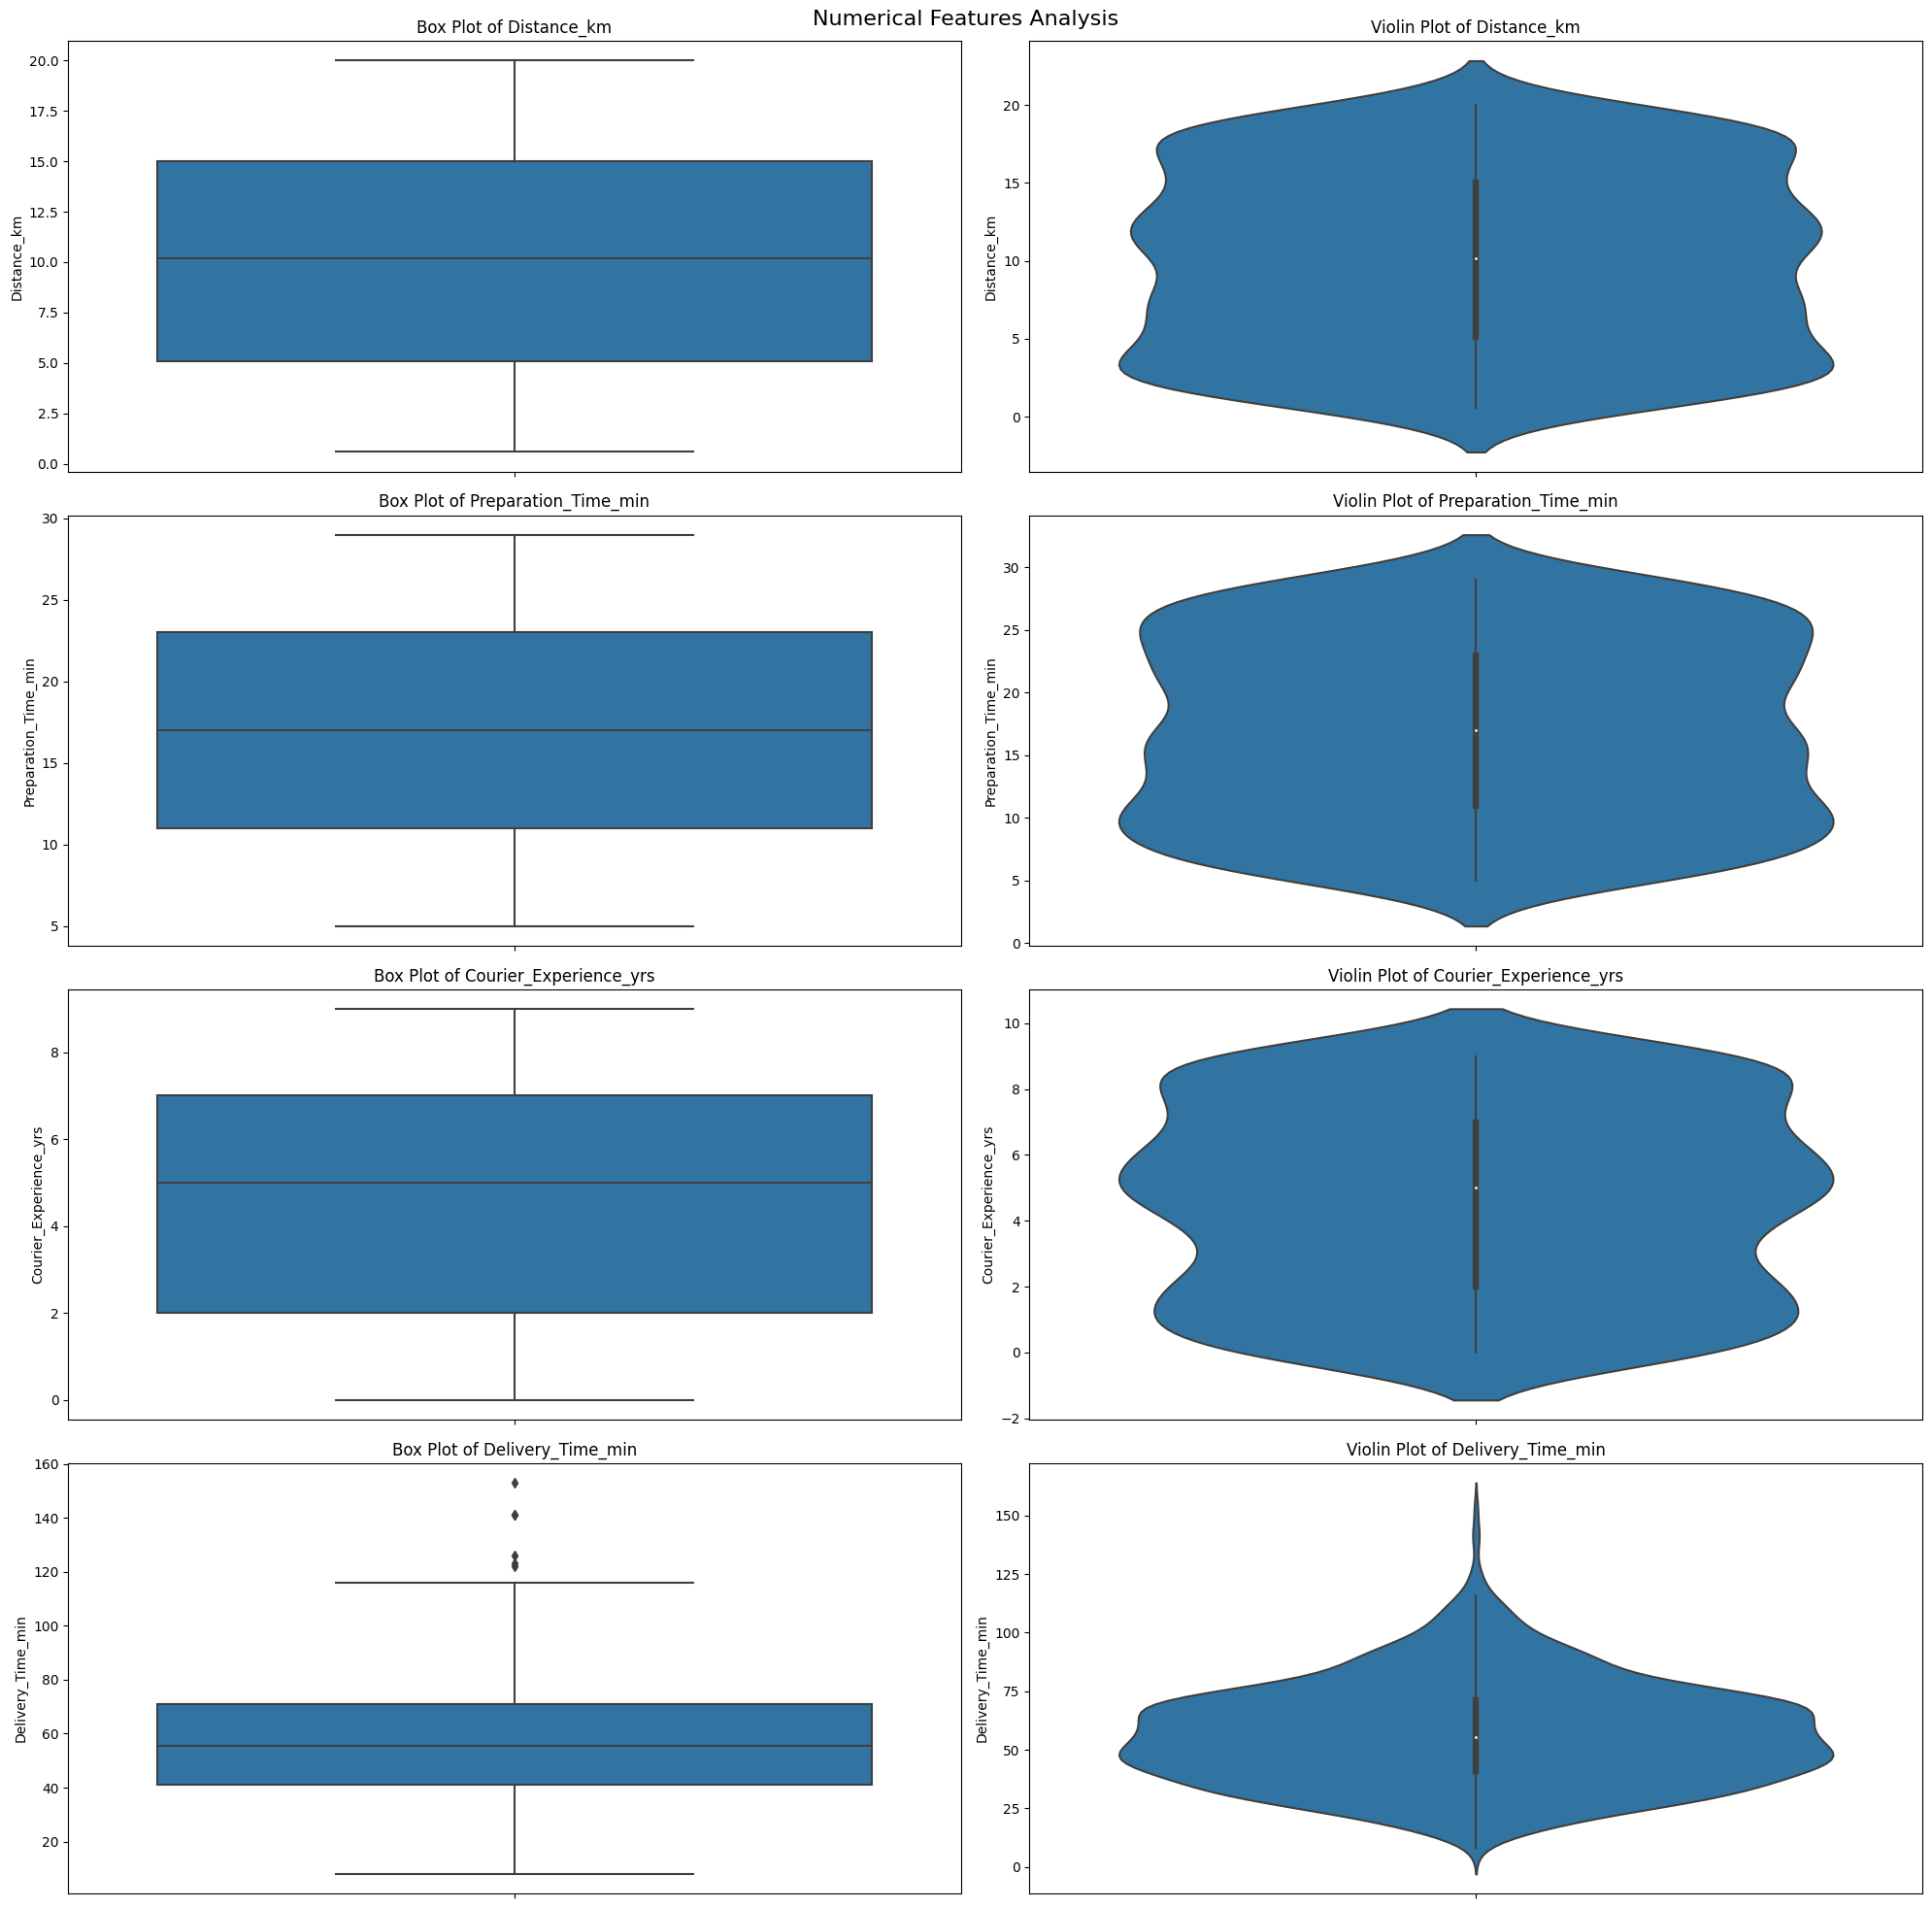

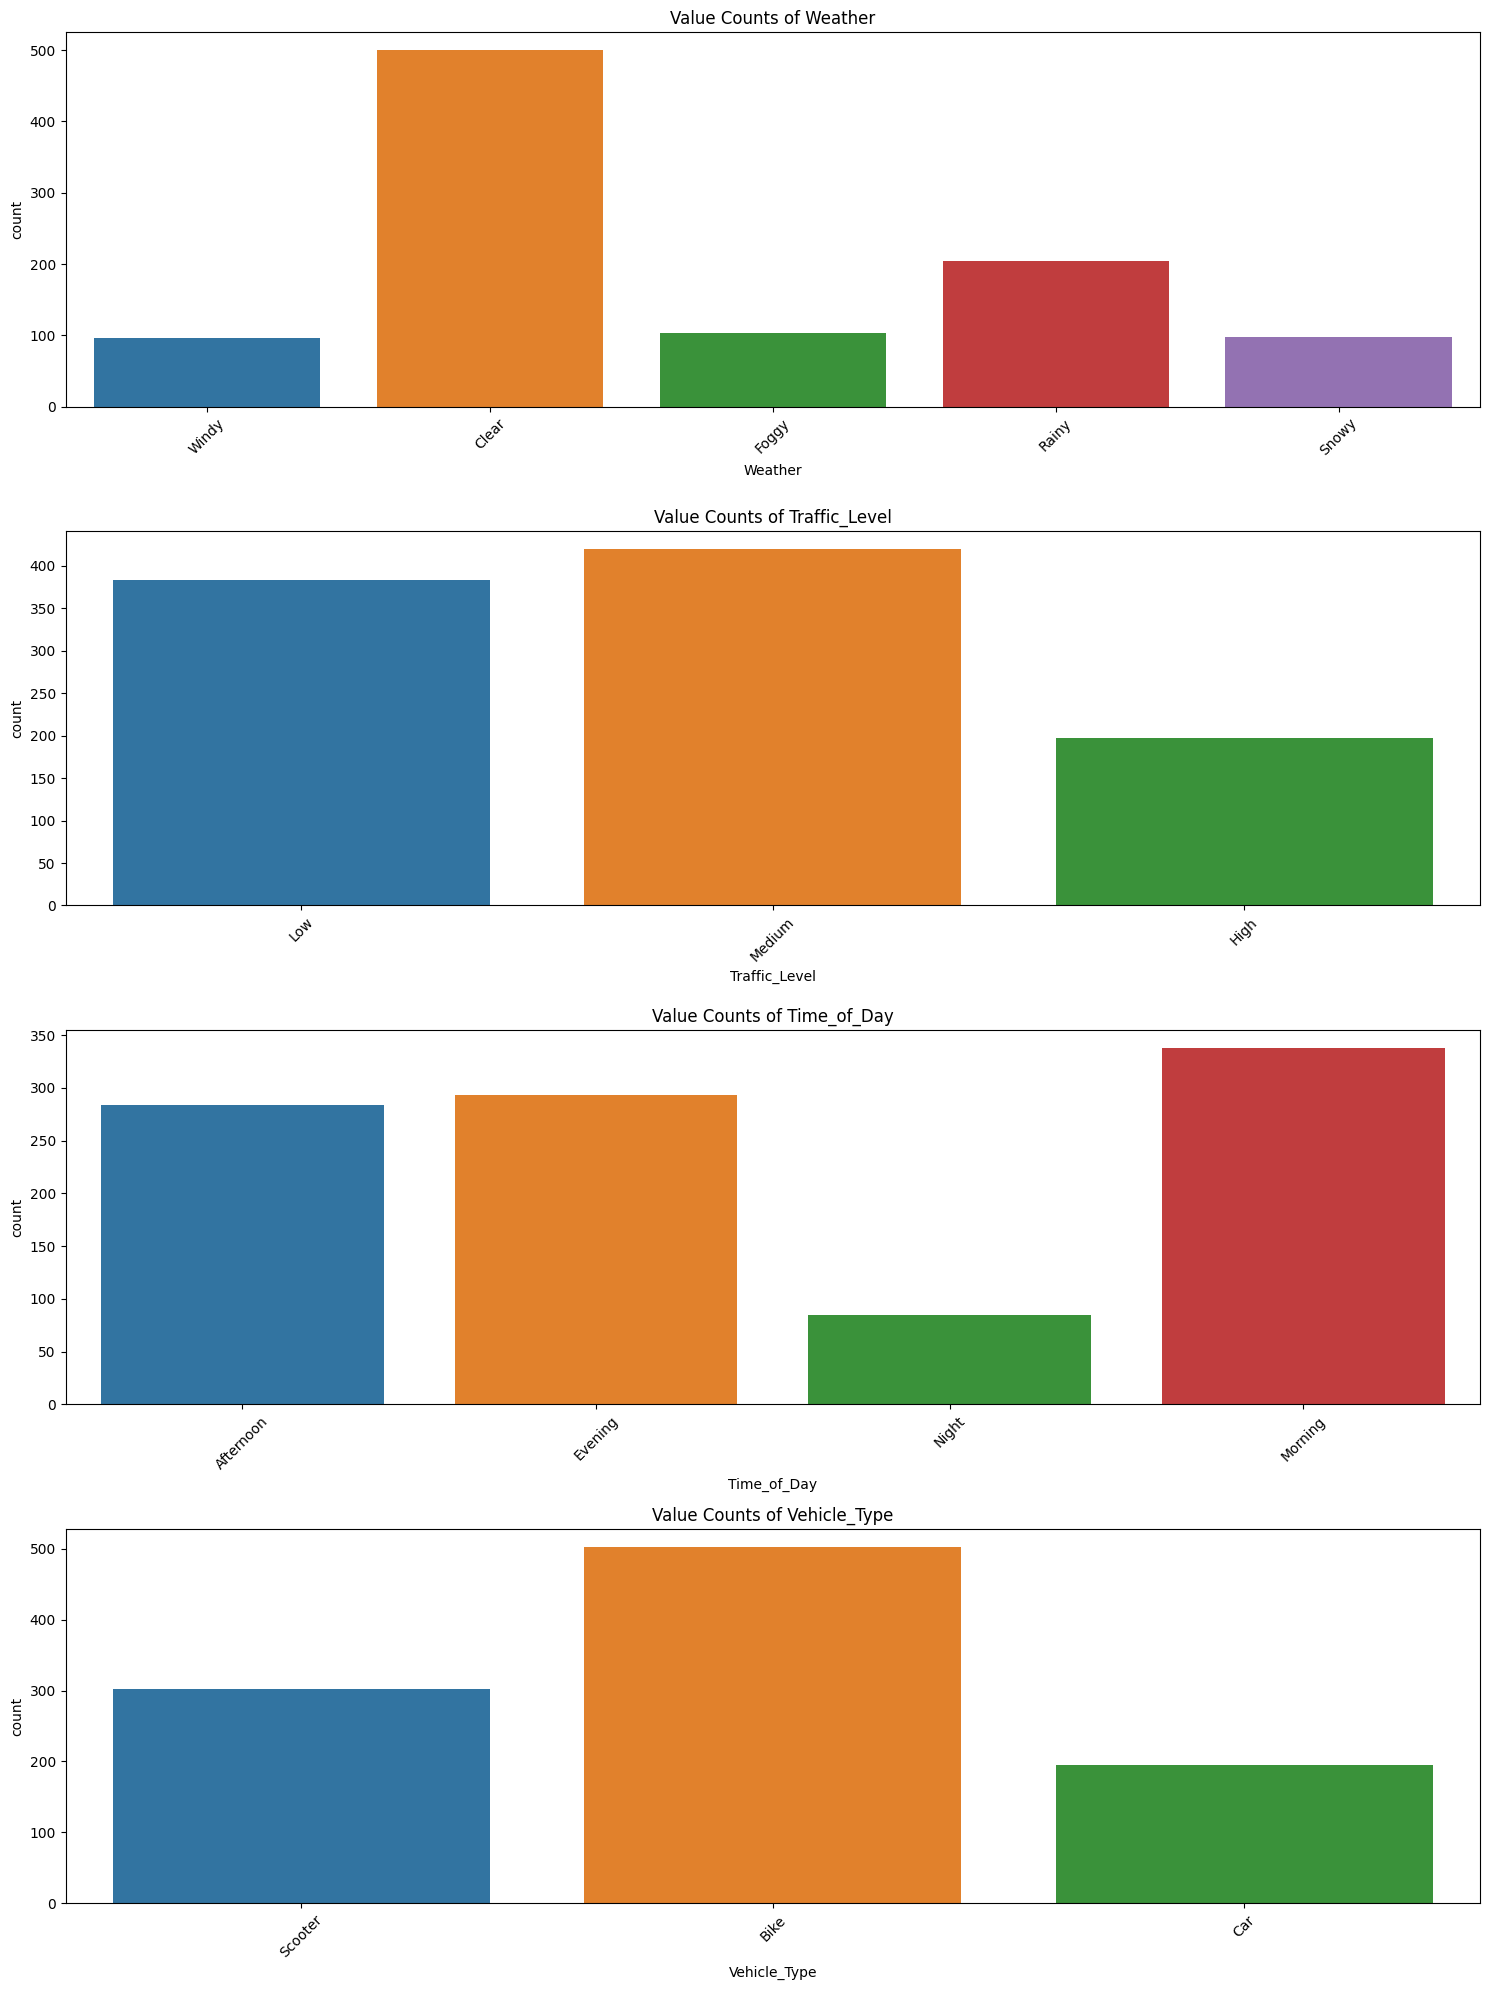


Numerical Features Summary:
       Distance_km  Preparation_Time_min  Courier_Experience_yrs  \
count  1000.000000           1000.000000             1000.000000   
mean     10.059970             16.982000                4.592000   
std       5.696656              7.204553                2.871198   
min       0.590000              5.000000                0.000000   
25%       5.105000             11.000000                2.000000   
50%      10.190000             17.000000                5.000000   
75%      15.017500             23.000000                7.000000   
max      19.990000             29.000000                9.000000   

       Delivery_Time_min  
count        1000.000000  
mean           56.732000  
std            22.070915  
min             8.000000  
25%            41.000000  
50%            55.500000  
75%            71.000000  
max           153.000000  

Categorical Features Summary:

Value counts for Weather:
Weather
Clear    500
Rainy    204
Foggy    103
Snowy     

In [4]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
numeric_cols = [col for col in numeric_cols if col != 'Order_ID']
categorical_cols = data.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(20, 5*len(numeric_cols)))
fig.suptitle('Numerical Features Analysis', fontsize=16)

for idx, col in enumerate(numeric_cols):
    
    sns.boxplot(data=data, y=col, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Box Plot of {col}')
    
    sns.violinplot(data=data, y=col, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Violin Plot of {col}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5*len(categorical_cols)))

for idx, col in enumerate(categorical_cols, 1):
    plt.subplot(len(categorical_cols), 1, idx)
    sns.countplot(data=data, x=col)
    plt.title(f'Value Counts of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


print("\nNumerical Features Summary:")
print(data[numeric_cols].describe())

print("\nCategorical Features Summary:")
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())


#### Observations & Insights

- Delivery time is highly variable, likely influenced by distance, traffic, and weather.
- High traffic levels and poor weather conditions may contribute to longer delivery times.
- Morning and evening have the highest order volumes, indicating peak hours.
- The dominance of bikes and scooters suggests an emphasis on quick, urban deliveries.



#### **Splitting Data**

In [5]:
X = data.drop(columns=['Order_ID', 'Delivery_Time_min'])
y = data['Delivery_Time_min']

numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

train_data, temp_data, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
val_data, test_data, y_val, y_test = train_test_split(temp_data, y_temp, test_size=0.5, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

train_transformed = preprocessor.fit_transform(train_data)
val_transformed = preprocessor.fit_transform(val_data)
test_transformed = preprocessor.fit_transform(test_data)

train_transformed_df = pd.DataFrame(train_transformed)
val_transformed_df = pd.DataFrame(val_transformed)
test_transformed_df = pd.DataFrame(test_transformed)

print(f"Number of datapoints in training set: {train_transformed_df.shape[0]}")
print(f"Number of datapoints in validation set: {val_transformed_df.shape[0]}")
print(f"Number of datapoints in test set: {test_transformed_df.shape[0]}")

Number of datapoints in training set: 700
Number of datapoints in validation set: 150
Number of datapoints in test set: 150


### **2.2**

#### **Gradient Descent**

In [6]:
class LinearRegressionGD:
    def __init__(self, learning_rate=0.05, n_iterations=1000, init_method='zero'):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.init_method = init_method
        self.train_losses = []
        self.val_losses = []
        
    def initialize_weights(self, n_features):
        if self.init_method == 'zero':
            self.weights = np.zeros(n_features)
            self.bias = 0
        else:
            self.weights = np.random.randn(n_features) * 0.01
            self.bias = np.random.randn() * 0.01
    
    def compute_loss(self, X, y):
        predictions = self.predict(X)
        return np.mean((predictions - y) ** 2)
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def evaluate_performance(self, X_test, y_test):
        predictions = self.predict(X_test)
        mse = np.mean((predictions - y_test) ** 2)
        r2 = r2_score(y_test, predictions)
        return mse, r2
    
    def batch_gradient_descent(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            predictions = self.predict(X_train)
            
            dw = (2/m) * np.dot(X_train.T, (predictions - y_train))
            db = (2/m) * np.sum(predictions - y_train)
            
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
    
    def mini_batch_gradient_descent(self, X_train, y_train, X_val, y_val, batch_size=32):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(0, m, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                
                predictions = self.predict(X_batch)
                
                dw = (2/len(X_batch)) * np.dot(X_batch.T, (predictions - y_batch))
                db = (2/len(X_batch)) * np.sum(predictions - y_batch)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break
    
    def stochastic_gradient_descent(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(m):
                X_i = X_shuffled[i:i+1]
                y_i = y_shuffled[i:i+1]
                
                prediction = self.predict(X_i)
                
                dw = 2 * np.dot(X_i.T, (prediction - y_i))
                db = 2 * (prediction - y_i)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"Converged at iteration {iteration}")
                break

#### **Plotting**

In [7]:
def plot_learning_curves(model_results, title):
    plt.figure(figsize=(12, 6))
    iterations = range(0, len(model_results['train_losses']) * 10, 10)
    
    plt.plot(iterations, model_results['train_losses'], label='Training Loss')
    plt.plot(iterations, model_results['val_losses'], label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('MSE Loss')
    plt.title(f'{title} Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

#### **Training the models**

Converged at iteration 670


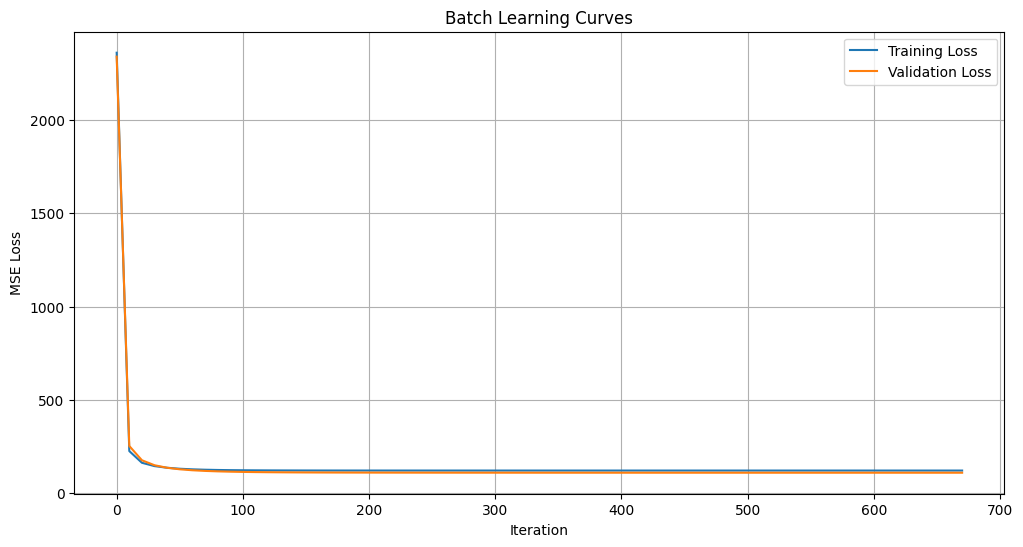

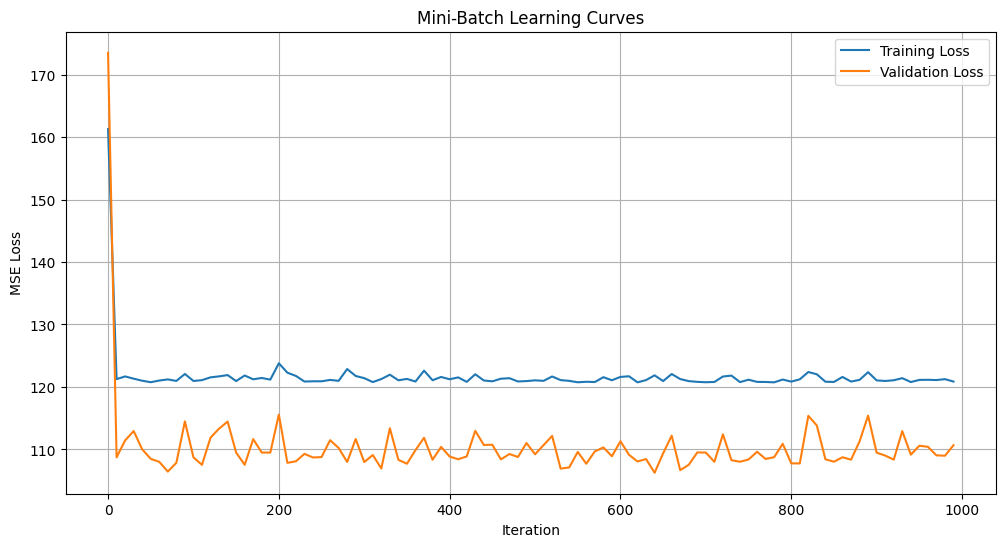

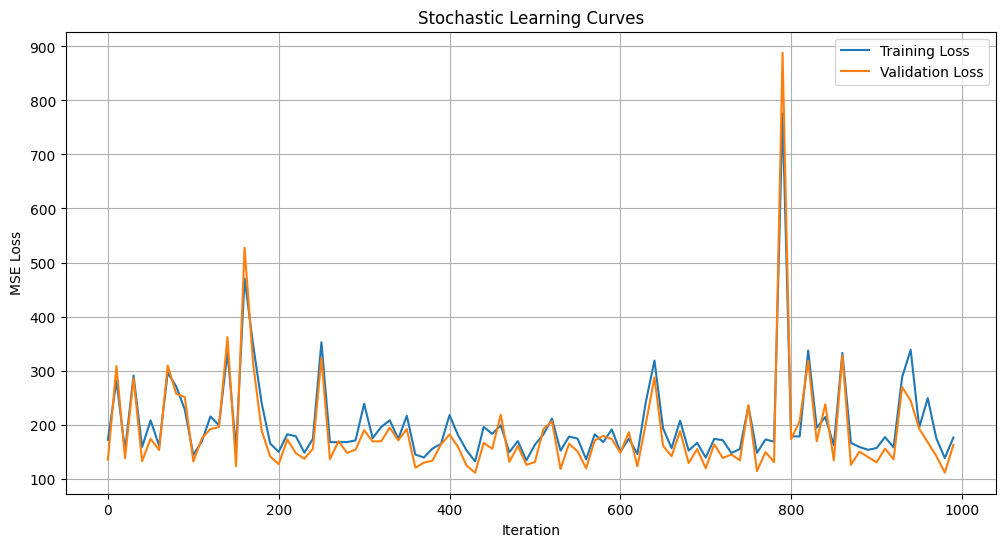


Final Performance Metrics:
------------------------------------------------------------
Method          Test MSE        R² Score       
------------------------------------------------------------
Batch           68.3127         0.8355         
Mini-Batch      72.5156         0.8253         
Stochastic      103.0410        0.7518         


In [8]:
X_train = train_transformed.toarray() if hasattr(train_transformed, 'toarray') else train_transformed
X_val = val_transformed.toarray() if hasattr(val_transformed, 'toarray') else val_transformed
X_test = test_transformed.toarray() if hasattr(test_transformed, 'toarray') else test_transformed

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

methods = {
    'Batch': lambda m: m.batch_gradient_descent(X_train, y_train, X_val, y_val),
    'Mini-Batch': lambda m: m.mini_batch_gradient_descent(X_train, y_train, X_val, y_val),
    'Stochastic': lambda m: m.stochastic_gradient_descent(X_train, y_train, X_val, y_val)
}

results = {}
for name, train_method in methods.items():
    model = LinearRegressionGD(learning_rate=0.05, n_iterations=1000)
    train_method(model)
    
    results[name] = {
        'train_losses': model.train_losses,
        'val_losses': model.val_losses
    }
    
    test_mse, test_r2 = model.evaluate_performance(X_test, y_test)
    results[name]['test_mse'] = test_mse
    results[name]['test_r2'] = test_r2
    
    plot_learning_curves(results[name], name)

print("\nFinal Performance Metrics:")
print("-" * 60)
print(f"{'Method':<15} {'Test MSE':<15} {'R² Score':<15}")
print("-" * 60)
for method, metrics in results.items():
    print(f"{method:<15} {metrics['test_mse']:<15.4f} {metrics['test_r2']:<15.4f}")

### **2.3**

#### **Model**

In [9]:
class RegularizedRegression:
    def __init__(self, reg_type='ridge', learning_rate=0.05, lambda_param=0.5, n_iterations=1000):
        self.reg_type = reg_type
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iterations = n_iterations
        self.train_losses = []
        self.val_losses = []
        
    def initialize_weights(self, n_features):
        self.weights = np.zeros(n_features)
        self.bias = 0
    
    def predict(self, X):
        return np.dot(X, self.weights) + self.bias
    
    def compute_loss(self, X, y):
        predictions = self.predict(X)
        mse = np.mean((predictions - y) ** 2)
        
        if self.reg_type == 'ridge':

            reg_term = self.lambda_param * np.sum(self.weights ** 2)
        else:  # lasso

            reg_term = self.lambda_param * np.sum(np.abs(self.weights))
            
        return mse + reg_term
    
    def compute_regularization_gradient(self):
        if self.reg_type == 'ridge':

            return 2 * self.lambda_param * self.weights
        else:  # lasso

            return self.lambda_param * np.sign(self.weights)
    
    def train(self, X_train, y_train, X_val, y_val):
        m = X_train.shape[0]
        self.initialize_weights(X_train.shape[1])
        
        for iteration in range(self.n_iterations):
            indices = np.random.permutation(m)
            X_shuffled = X_train[indices]
            y_shuffled = y_train[indices]
            
            for i in range(m):
                X_i = X_shuffled[i:i+1]
                y_i = y_shuffled[i:i+1]
                
                prediction = self.predict(X_i)
                
                dw = 2 * np.dot(X_i.T, (prediction - y_i))
                reg_gradient = self.compute_regularization_gradient()
                dw += reg_gradient
                
                db = 2 * (prediction - y_i)
                
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db
            
            if iteration % 10 == 0:
                train_loss = self.compute_loss(X_train, y_train)
                val_loss = self.compute_loss(X_val, y_val)
                self.train_losses.append(train_loss)
                self.val_losses.append(val_loss)
            
            if len(self.train_losses) > 1 and abs(self.train_losses[-1] - self.train_losses[-2]) < 1e-6:
                print(f"{self.reg_type.capitalize()} regression converged at iteration {iteration}")
                break
    
    def evaluate(self, X_test, y_test):
        predictions = self.predict(X_test)
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        return mse, r2

#### **Plotting**

In [10]:
def plot_learning_curves_1(model, title):
    plt.figure(figsize=(12, 6))
    iterations = range(0, len(model.train_losses) * 10, 10)
    
    plt.plot(iterations, model.train_losses, label='Training Loss')
    plt.plot(iterations, model.val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (MSE + Regularization)')
    plt.title(f'{title} Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

#### **Training**


Training Ridge Regression...


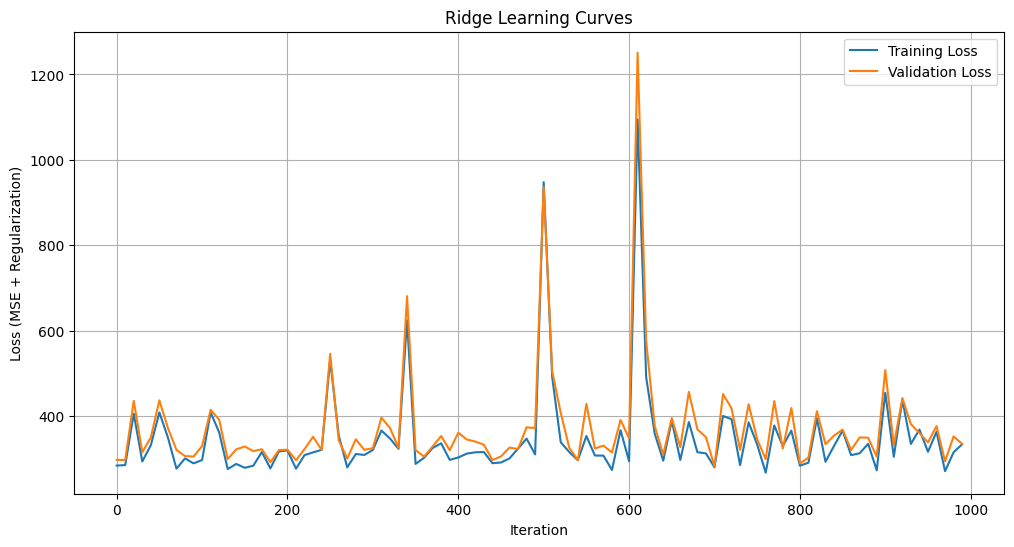


Ridge Regression Results:
Test MSE: 134.0922
R² Score: 0.6770
Average absolute coefficient value: 2.1201

Training Lasso Regression...


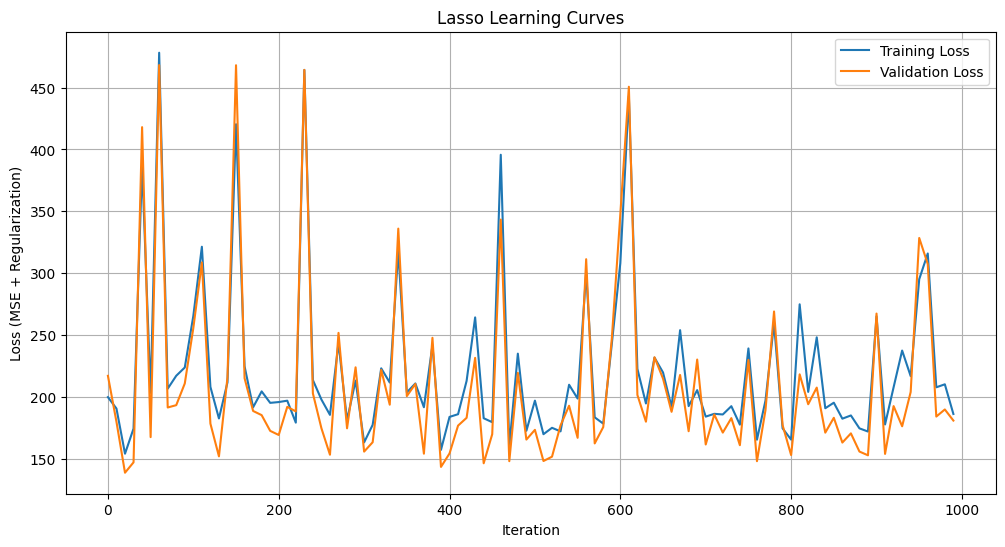


Lasso Regression Results:
Test MSE: 83.3273
R² Score: 0.7993
Average absolute coefficient value: 3.0547

Comparison Summary:
------------------------------------------------------------
Method          Test MSE        R² Score       
------------------------------------------------------------
Ridge           134.0922        0.6770         
Lasso           83.3273         0.7993         


In [11]:
X_train = train_transformed.toarray() if hasattr(train_transformed, 'toarray') else train_transformed
X_val = val_transformed.toarray() if hasattr(val_transformed, 'toarray') else val_transformed
X_test = test_transformed.toarray() if hasattr(test_transformed, 'toarray') else test_transformed

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

models = {
    'Ridge': RegularizedRegression(reg_type='ridge', lambda_param=0.5),
    'Lasso': RegularizedRegression(reg_type='lasso', lambda_param=0.5)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name} Regression...")
    model.train(X_train, y_train, X_val, y_val)
    
    test_mse, test_r2 = model.evaluate(X_test, y_test)
    
    results[name] = {
        'model': model,
        'test_mse': test_mse,
        'test_r2': test_r2
    }
    
    plot_learning_curves_1(model, name)
    
    near_zero_coef = np.sum(np.abs(model.weights) < 1e-4)
    print(f"\n{name} Regression Results:")
    print(f"Test MSE: {test_mse:.4f}")
    print(f"R² Score: {test_r2:.4f}")
    print(f"Average absolute coefficient value: {np.mean(np.abs(model.weights)):.4f}")

print("\nComparison Summary:")
print("-" * 60)
print(f"{'Method':<15} {'Test MSE':<15} {'R² Score':<15}")
print("-" * 60)
for method, metrics in results.items():
    print(f"{method:<15} {metrics['test_mse']:<15.4f} {metrics['test_r2']:<15.4f}")

#### **Analyzing and Finding Lambda**


Training Ridge models with different λ values...

Training Lasso models with different λ values...


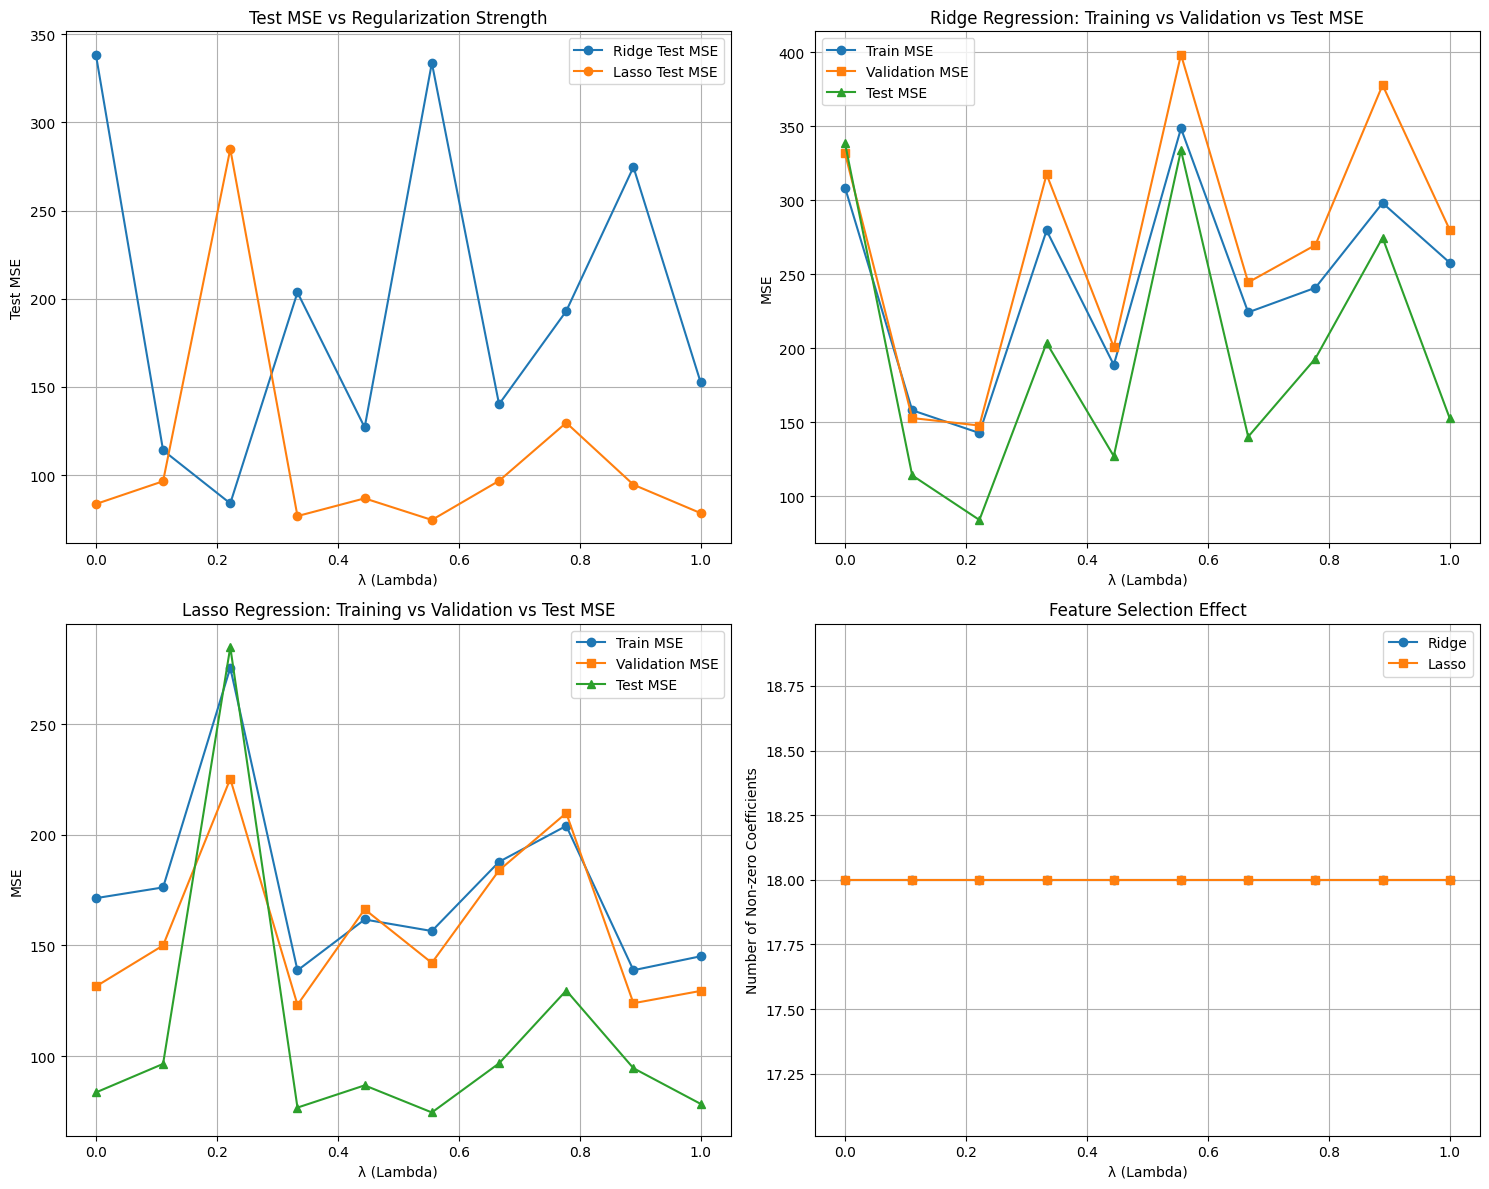


Optimal Regularization Parameters:
Ridge optimal λ: 0.2222
Lasso optimal λ: 0.5556

Minimum Test MSE Values:
Ridge: 83.8957
Lasso: 74.5140


In [13]:
def analyze_regularization_impact(X_train, y_train, X_val, y_val, X_test, y_test):

    lambda_values = np.linspace(0, 1, 10)
    
    results = {
        'ridge': {'test_mse': [], 'train_mse': [], 'val_mse': [], 'nonzero_coef': []},
        'lasso': {'test_mse': [], 'train_mse': [], 'val_mse': [], 'nonzero_coef': []}
    }
    
    for reg_type in ['ridge', 'lasso']:
        print(f"\nTraining {reg_type.capitalize()} models with different λ values...")
        
        for lambda_param in lambda_values:
            model = RegularizedRegression(reg_type=reg_type, lambda_param=lambda_param)
            model.train(X_train, y_train, X_val, y_val)
            
            train_pred = model.predict(X_train)
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            results[reg_type]['train_mse'].append(mean_squared_error(y_train, train_pred))
            results[reg_type]['val_mse'].append(mean_squared_error(y_val, val_pred))
            results[reg_type]['test_mse'].append(mean_squared_error(y_test, test_pred))
            
            nonzero_coef = np.sum(np.abs(model.weights) > 1e-4)
            results[reg_type]['nonzero_coef'].append(nonzero_coef)
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    for reg_type in ['ridge', 'lasso']:
        ax1.plot(lambda_values, results[reg_type]['test_mse'], 
                label=f'{reg_type.capitalize()} Test MSE', marker='o')
    ax1.set_xlabel('λ (Lambda)')
    ax1.set_ylabel('Test MSE')
    ax1.set_title('Test MSE vs Regularization Strength')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(lambda_values, results['ridge']['train_mse'], label='Train MSE', marker='o')
    ax2.plot(lambda_values, results['ridge']['val_mse'], label='Validation MSE', marker='s')
    ax2.plot(lambda_values, results['ridge']['test_mse'], label='Test MSE', marker='^')
    ax2.set_xlabel('λ (Lambda)')
    ax2.set_ylabel('MSE')
    ax2.set_title('Ridge Regression: Training vs Validation vs Test MSE')
    ax2.legend()
    ax2.grid(True)
    
    ax3.plot(lambda_values, results['lasso']['train_mse'], label='Train MSE', marker='o')
    ax3.plot(lambda_values, results['lasso']['val_mse'], label='Validation MSE', marker='s')
    ax3.plot(lambda_values, results['lasso']['test_mse'], label='Test MSE', marker='^')
    ax3.set_xlabel('λ (Lambda)')
    ax3.set_ylabel('MSE')
    ax3.set_title('Lasso Regression: Training vs Validation vs Test MSE')
    ax3.legend()
    ax3.grid(True)
    
    ax4.plot(lambda_values, results['ridge']['nonzero_coef'], 
             label='Ridge', marker='o')
    ax4.plot(lambda_values, results['lasso']['nonzero_coef'], 
             label='Lasso', marker='s')
    ax4.set_xlabel('λ (Lambda)')
    ax4.set_ylabel('Number of Non-zero Coefficients')
    ax4.set_title('Feature Selection Effect')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    ridge_opt_lambda = lambda_values[np.argmin(results['ridge']['test_mse'])]
    lasso_opt_lambda = lambda_values[np.argmin(results['lasso']['test_mse'])]
    
    print("\nOptimal Regularization Parameters:")
    print(f"Ridge optimal λ: {ridge_opt_lambda:.4f}")
    print(f"Lasso optimal λ: {lasso_opt_lambda:.4f}")
    
    print("\nMinimum Test MSE Values:")
    print(f"Ridge: {min(results['ridge']['test_mse']):.4f}")
    print(f"Lasso: {min(results['lasso']['test_mse']):.4f}")

analyze_regularization_impact(X_train, y_train, X_val, y_val, X_test, y_test)

## **2.4 Report**

### **Difference between Types of GDA**

#### 1. Batch Gradient Descent
##### Description:
- Computes the gradient using the entire dataset.
- Updates weights after processing all training samples.

##### Advantages:
- Converges smoothly due to stable updates.
- More efficient for convex loss functions.

##### Disadvantages:
- Slow for large datasets due to full dataset computation.
- Can get stuck in local minima.

---

#### 2. Stochastic Gradient Descent (SGD)
##### Description:
- Updates weights after computing the gradient for a single training sample.

##### Advantages:
- Faster updates, allowing quicker learning.
- Can escape local minima due to randomness.

##### Disadvantages:
- High variance in updates, leading to instability.
- Noisy convergence, requiring learning rate decay.

---

#### 3. Mini-Batch Gradient Descent
##### Description:
- Computes the gradient on a small batch of samples before updating weights.

##### Advantages:
- Balances stability and efficiency.
- Uses vectorized operations, improving computation speed.

##### Disadvantages:
- Still has some variance in updates compared to batch GD.
- Requires tuning batch size for optimal performance.

---

#### Which Converges the Fastest?
- **Stochastic Gradient Descent (SGD)** generally converges the fastest in terms of iteration count but may be noisy.
- **Mini-Batch Gradient Descent** offers a good balance between speed and stability, often preferred in deep learning.
- **Batch Gradient Descent** is the slowest but most stable.



### Regularization Impact on Model Performance

#### Comparison Summary:
| Method | Test MSE | R² Score |
|--------|---------|----------|
| Ridge  | 134.0922 | 0.6770   |
| Lasso  | 83.3273  | 0.7993   |

For $\lambda = 0.5$, the above results were obtained.

#### Optimal Regularization Parameters:
- **Ridge optimal $\lambda$**: 0.2222
- **Lasso optimal $\lambda$**: 0.5556

#### Minimum Test MSE Values:
- **Ridge**: 83.8957
- **Lasso**: 74.5140

#### Influence of Regularization:
- **Ridge**: Helps reduce model complexity by shrinking coefficients, preventing overfitting while maintaining important features.
- **Lasso**: Performs feature selection by forcing some coefficients to zero, leading to a sparse model.

##### Optimal $\lambda$ Selection:
- Ridge: $\lambda = 0.2222$ (yields the best test MSE)
- Lasso: $\lambda = 0.5556$ (yields the best test MSE)

### Impact of Feature Scaling:
- **Standardization** is crucial for both Ridge and Lasso as these methods are sensitive to feature magnitudes.
- Scaling ensures that no single feature dominates due to large numeric ranges.
- Improves convergence and stability of gradient-based optimizers.



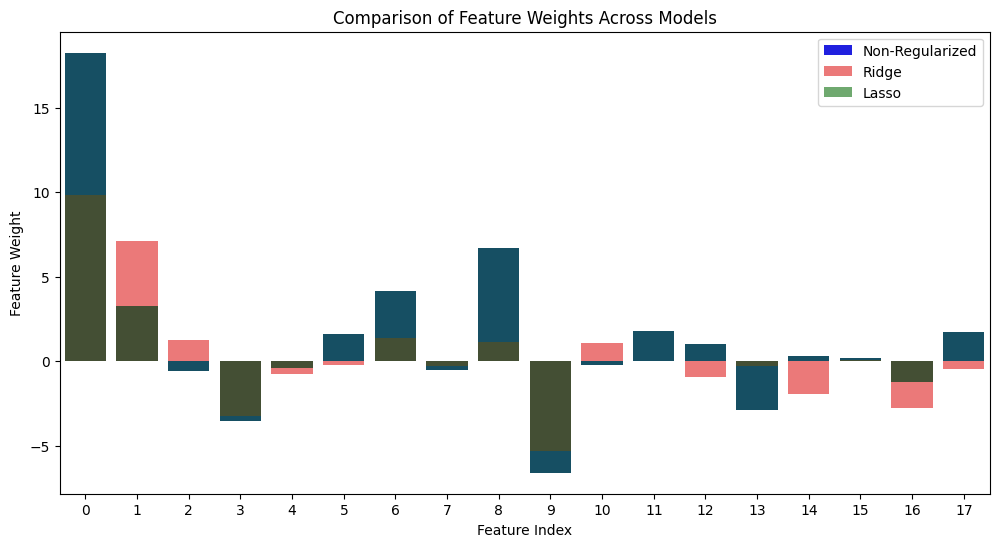

Number of near-zero weights in Lasso: 5
Features with nearly zero effect on delivery time: [ 4  7 10 14 15]


In [22]:
ridge_weights = results['Ridge']['model'].weights
lasso_weights = results['Lasso']['model'].weights

best_method = min(results.items(), key=lambda x: x[1]['test_mse'])[0]
non_reg_model = results[best_method]['model']
non_reg_weights = non_reg_model.weights

feature_indices = np.arange(len(ridge_weights))

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_indices, y=non_reg_weights, color='blue', label='Non-Regularized')
sns.barplot(x=feature_indices, y=ridge_weights, color='red', alpha=0.6, label='Ridge')
sns.barplot(x=feature_indices, y=lasso_weights, color='green', alpha=0.6, label='Lasso')

plt.xlabel("Feature Index")
plt.ylabel("Feature Weight")
plt.title("Comparison of Feature Weights Across Models")
plt.legend()
plt.show()

near_zero_lasso = np.sum(np.abs(lasso_weights) < 0.5)
print(f"Number of near-zero weights in Lasso: {near_zero_lasso}")

zero_effect_features = np.where(np.abs(lasso_weights) < 0.5)[0]
print(f"Features with nearly zero effect on delivery time: {zero_effect_features}")